In [1]:
"""
Created on Wed Aug  4 17:50:06 2021

@author: amol
"""

# set TF GPU memory growth so that it doesn't hog everything at once
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from main import *
debug_mode = True  # faster experiments for debugging

In [2]:
#Prepare the DataFrame that will be used downstream
dp = DataPreparer()
dp.createPCAs()
dp.sparsePCAs()
dp.zmixOrthogonalPCAs()
df = dp.getDataframe()

df.to_csv('PCA_data.csv', index=False)

'''
print(df[dp.pure_pca_dim_cols].describe().transpose())
print(df[dp.sparse_pca_dim_cols].describe().transpose())
print(df[dp.zmix_pca_dim_cols].describe().transpose())
'''
# currently passing dp eventually we want to abstract all the constants into 1 class
dm = DataManager(df, dp)

In [3]:
print(df)

              X         YiCH4           YiH           YiO      YiO2  \
0      0.004906  2.087462e-13  1.416763e-06  2.734865e-04  0.975537   
1      0.010641  3.585189e-13  5.090490e-06  6.871092e-04  0.946874   
2      0.015364  3.930431e-13  9.854039e-06  1.183715e-03  0.923112   
3      0.019593  3.608023e-13  1.475975e-05  1.796256e-03  0.901632   
4      0.023507  2.961475e-13  1.947031e-05  2.501742e-03  0.881558   
...         ...           ...           ...           ...       ...   
16434  0.924396  8.958042e-01  5.582736e-08  6.708362e-08  0.018040   
16435  0.930561  9.042967e-01  4.988934e-08  6.160746e-08  0.016562   
16436  0.936868  9.129859e-01  4.423880e-08  5.601146e-08  0.015052   
16437  0.943333  9.218933e-01  3.883153e-08  5.027931e-08  0.013506   
16438  0.949974  9.310451e-01  3.361912e-08  4.439230e-08  0.011919   

               YiOH     YiH2O     YiHO2    YiH2O2           YiC  ...  \
0      2.252565e-04  0.010766  0.000126  0.000009  2.073137e-15  ...   
1  

In [4]:
'''
class ModelInspector:
    """ Abstract model inspector (e.g. error analysis) """
    def __init__(self, model_factory, dm):
        experiment_settings = model_factory.experimentSettings
        dm.createTrainTestData(dataSetMethod=experiment_settings['dataSetMethod'], numCpvComponents=experiment_settings['noOfCpv'],
                               ipscaler=experiment_settings['ipscaler'], opscaler=experiment_settings['opscaler'])

        # wrap model for use with scipy
        if isinstance(model_factory, DNNModelFactory):
            model_wrapper = NNWrapper(model_factory.getRegressor(), concatenate_zmix=experiment_settings['concatenateZmix'])
        else:
            assert type(model_factory.model) is CustomGPR
            model_wrapper = GPWrapper(model_factory.model)

        self._model_factory = model_factory
        self._model = model_wrapper
        self._dm = dm
        self._X_data, self._Y_data = self._model.get_XY_data(self._dm)

        if isinstance(model_factory, DNNModelFactory):
            linearAutoEncoder = model_factory.getLinearEncoder()
            zmix = self._X_data['zmix']
            self._X_data = self._X_data.drop('zmix', axis=1)
            self._X_data = np.concatenate((np.asarray(zmix).reshape([-1, 1]),
                                           linearAutoEncoder.predict(self._X_data)), axis=1)
                                            # Zmix is on the left

            X_column_names = ['zmix'] + [f'cpv{i+1}' for i in range(experimentSettings['noOfCpv'])]
            print(X_column_names)
            self._X_data = pd.DataFrame(columns=X_column_names, data=self._X_data)

    def plot_partial_dependence(self, features: list = None):
        features=list(range(min(self._X_data.shape[1], 25)))

        # this gives us the same dataframe but with only quartiles for each variable
        # thereby covering the relevant ranges but much faster
        X_chunky=self._X_data.describe().iloc[3:]
        print(X_chunky)

        plot_partial_dependence(self._model, X_chunky, features=features)

    def plot_permutation_feature_importance(self, n_repeats=5):
        do_perm_feature_importance(self._model, self._X_data, self._Y_data, n_repeats=n_repeats)
'''

'\nclass ModelInspector:\n    """ Abstract model inspector (e.g. error analysis) """\n    def __init__(self, model_factory, dm):\n        experiment_settings = model_factory.experimentSettings\n        dm.createTrainTestData(dataSetMethod=experiment_settings[\'dataSetMethod\'], numCpvComponents=experiment_settings[\'noOfCpv\'],\n                               ipscaler=experiment_settings[\'ipscaler\'], opscaler=experiment_settings[\'opscaler\'])\n\n        # wrap model for use with scipy\n        if isinstance(model_factory, DNNModelFactory):\n            model_wrapper = NNWrapper(model_factory.getRegressor(), concatenate_zmix=experiment_settings[\'concatenateZmix\'])\n        else:\n            assert type(model_factory.model) is CustomGPR\n            model_wrapper = GPWrapper(model_factory.model)\n\n        self._model_factory = model_factory\n        self._model = model_wrapper\n        self._dm = dm\n        self._X_data, self._Y_data = self._model.get_XY_data(self._dm)\n\n       

In [5]:
'''
class NNWrapper(BaseEstimator, RegressorMixin):
    """Wraps Amol's NN classes to comform to the interface expected by SciPy"""
    def __init__(self, model, concatenate_zmix=None):
        # QUESTION: what are the things that concatenate_zmix does currently?
        super().__init__()
        self._model = model
        self._input_names = [i.name for i in model.inputs]
        print(f'input names: {self._input_names}')
        if concatenate_zmix is None:
            self._concatenate_zmix = 'zmix' in self._input_names
        else:
            self._concatenate_zmix = concatenate_zmix

        # this tells sklearn that the model is fitted apparently... (as of version 1.6.2)
        # https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/utils/validation.py
        self._I_am_fitted_ = 'nonsense_value'

    def get_XY_data(self, dm):
        """
        Extracts appropriate X & Y data from data-manager for evaluation of our model.
        (assumes that datamanager was already called to create relevant dataset)
        """
        X_data = np.concatenate((dm.X_test, dm.zmix_test.reshape([-1, 1])), axis=1) if self._concatenate_zmix else dm.X_test
        extra_input_cols = ['zmix'] if self._concatenate_zmix else []
        Y_data = dm.Y_test

        X_data = pd.DataFrame(X_data.astype('f8'), columns=extra_input_cols+list(dm.input_data_cols))
        Y_data = pd.DataFrame(Y_data.astype('f8'), columns=dm.output_data_cols)
        return X_data, Y_data
    
    #### DEPRECATED... ####
    def _get_input_dict(self, X_data: pd.DataFrame):
        # TODO: make this not drop zmix if it is 'present' but not 'concatenated'
        zmix = X_data['zmix']
        X_data = X_data.drop(columns='zmix')
        X_data = np.asarray(X_data)

        # self._input_names[0] == 'species_input' or 'inputs' depending on NN version
        if self._concatenate_zmix:
            input_dict = {self._input_names[0]: X_data}
            input_dict['zmix'] = zmix
        else:
            assert len(self._input_names)==1
            input_dict= {self._input_names[0]: np.asarray(X_data)}
            # QUESTION: are we sure the order is right here?
        return input_dict

    def predict(self, X_data):
        return self._model.predict(X_data)
        #return self._model.predict(self._get_input_dict(X_data))

    def get_params(self, deep=True):
        return self._model.get_weights()

    def fit(self, X_data, Y_data):
        self._model.fit(X_data, Y_data, batch_size=32)
        #self._model.fit(self._get_input_dict(X_data), Y_data, batch_size=32)

'''

'\nclass NNWrapper(BaseEstimator, RegressorMixin):\n    """Wraps Amol\'s NN classes to comform to the interface expected by SciPy"""\n    def __init__(self, model, concatenate_zmix=None):\n        # QUESTION: what are the things that concatenate_zmix does currently?\n        super().__init__()\n        self._model = model\n        self._input_names = [i.name for i in model.inputs]\n        print(f\'input names: {self._input_names}\')\n        if concatenate_zmix is None:\n            self._concatenate_zmix = \'zmix\' in self._input_names\n        else:\n            self._concatenate_zmix = concatenate_zmix\n\n        # this tells sklearn that the model is fitted apparently... (as of version 1.6.2)\n        # https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/utils/validation.py\n        self._I_am_fitted_ = \'nonsense_value\'\n\n    def get_XY_data(self, dm):\n        """\n        Extracts appropriate X & Y data from data-manager for evaluation of our model.\n        (assum

In [3]:
'''
1. Run the GP Experiments
'''
import time

start=time.time()
exprExec = run_gp_experiments(dm, debug_mode=debug_mode)
print(f'duration: {time.time()-start}')

train_set_keys:  [25034, 15777, 32353, 23782, 2134, 7694, 3217, 9944, 7309, 4849, 21463, 11018, 14989, 10467, 3386, 20390, 5373, 9446, 3949, 3564, 18402, 6944, 30735, 12208, 3752, 14239, 2620]
test_set_keys:  [2758, 2246, 3056, 2364, 13527, 2027, 4376, 2903, 5104, 8974, 16608, 12851, 5656, 6267, 8099, 27738, 4157, 17482, 2489, 5953, 8525, 11598, 19371, 29198, 6597, 26352, 22593, 4606]
train:  [ 3752 11018 12208  3217  2620]
test:  [ 2903 27738  2758 12851 17482]
training model


KeyboardInterrupt: 

In [ ]:
'''
2. Run the Simple DNN Experiments
'''
exprExec = run_simple_dnn_experiments(dm, debug_mode=debug_mode)

In [ ]:
'''
3. Run the PCDNN_v1 Experiments
'''
exprExec = run_pcdnn_v1_experiments(dm, debug_mode=debug_mode)

In [3]:
'''
4. Run the PCDNN_v2 Experiments
'''
exprExec = run_pcdnn_v2_experiments(dm, debug_mode=debug_mode)

=================== randomequalflamesplit ===================
------------------ AllSpeciesAndZmix ------------------
--------------------self.build_and_compile_pcdnn_v2_model----------------------
53 2 Y Y Y
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
linear_embedding (Functional)   (None, 2)            108         species_input[0][0]              
___________________________________________________________________________________

ipdb> b 128
Breakpoint 1 at /home/dwyerdei/rom_project2/src/experiment_executor/pcdnn_v2_experiment_executor.py:128
ipdb> c
training model: 1
> /home/dwyerdei/rom_project2/src/experiment_executor/pcdnn_v2_experiment_executor.py(128)fitModelAndCalcErr()
    126 
    127             curr_errs = self.errManager.computeError (Y_pred, Y_test)
1-> 128 
    129             if (len(errs) == 0) or ((len(errs) > 0) and (curr_errs['MAE'] < self.min_mae)) :
    130                 self.min_mae = curr_errs['MAE']#MAE

ipdb> l
    123 
    124 
    125             #sns.residplot(Y_pred.flatten(), getResiduals(Y_test,Y_pred))
    126 
    127             curr_errs = self.errManager.computeError (Y_pred, Y_test)
1-> 128 
    129             if (len(errs) == 0) or ((len(errs) > 0) and (curr_errs['MAE'] < self.min_mae)) :
    130                 self.min_mae = curr_errs['MAE']#MAE
    131                 self.modelFactory.saveCurrModelAsBestModel()
    132 
    133             errs.append(curr_errs)

ip

ipdb> n
> /home/dwyerdei/rom_project2/src/experiment_executor/error_manager.py(24)computeError()
     22         evaluation_df_1['souener_pred_L2'] = evaluation_df_1['souener_pred_L1'] * evaluation_df_1['souener_pred_L1']
     23 
---> 24         evaluation_df_1['souener_pred_L1Percent'] = ((evaluation_df_1['souener'] - evaluation_df_1['souener_pred'])/evaluation_df_1['souener'])
     25 
     26         TotalAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()

ipdb> n
> /home/dwyerdei/rom_project2/src/experiment_executor/error_manager.py(26)computeError()
     24         evaluation_df_1['souener_pred_L1Percent'] = ((evaluation_df_1['souener'] - evaluation_df_1['souener_pred'])/evaluation_df_1['souener'])
     25 
---> 26         TotalAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()
     27 
     28         TotalSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()

ipdb> n
> /home/dwyerdei/rom_project2/src/experiment_executor/error_manager.py(28)comput

ipdb> n
> /home/dwyerdei/rom_project2/src/experiment_executor/error_manager.py(35)computeError()
     33 
     34         MeanRelativeError = (evaluation_df_1['souener_pred_L1']/evaluation_df_1['souener']).abs().sum()/evaluation_df_1['souener_pred_L1'].abs().count()
---> 35         TotalRelativeError = (evaluation_df_1['souener_pred_L1']/evaluation_df_1['souener']).abs().sum()/evaluation_df_1['souener_pred_L1'].abs().count()
     36 
     37         NumPoints = evaluation_df_1['souener_pred_L1Percent'].abs().count()

ipdb> n
> /home/dwyerdei/rom_project2/src/experiment_executor/error_manager.py(37)computeError()
     35         TotalRelativeError = (evaluation_df_1['souener_pred_L1']/evaluation_df_1['souener']).abs().sum()/evaluation_df_1['souener_pred_L1'].abs().count()
     36 
---> 37         NumPoints = evaluation_df_1['souener_pred_L1Percent'].abs().count()
     38 
     39         MeanPercentageError = evaluation_df_1['souener_pred_L1Percent'].abs().sum()/NumPoints

ipdb> n
> /ho

ipdb> 
     27 
     28         TotalSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()
     29 
     30         MeanAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()/evaluation_df_1['souener_pred_L1'].abs().count()
     31 
     32         MeanSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()/evaluation_df_1['souener_pred_L2'].abs().count()
     33 
     34         MeanRelativeError = (evaluation_df_1['souener_pred_L1']/evaluation_df_1['souener']).abs().sum()/evaluation_df_1['souener_pred_L1'].abs().count()
     35         TotalRelativeError = (evaluation_df_1['souener_pred_L1']/evaluation_df_1['souener']).abs().sum()/evaluation_df_1['souener_pred_L1'].abs().count()
     36 
     37         NumPoints = evaluation_df_1['souener_pred_L1Percent'].abs().count()

ipdb> p evaluation_df_1['souener_pred_L1'].abs().count()
8366
ipdb> p (evaluation_df_1['souener_pred_L1']/evaluation_df_1['souener']).abs().sum()
inf
ipdb> p evaluation_df_1['souener']
0       0

In [ ]:
# My version:
import model_analyzer.model_analysis as model_analysis
import pdb

import importlib
importlib.reload(model_analysis)

bestModel, experimentSettings = exprExec.modelFactory.openBestModel()
print(f'\nexperimentSettings: {experimentSettings}')
print(f'\nbestModel.input_shape: {bestModel.input_shape}')
inspector = model_analysis.ModelInspector(exprExec.modelFactory, dm)

In [ ]:
inspector.plot_permutation_feature_importance()

In [ ]:
inspector.plot_partial_dependence()

### Print & Record Linear Embeddings Output

In [8]:
import numpy as np

def inspect_PCA(X):
    PCA_dict = {}
    PCA_dict['X'] = X
    PCA_dict['Var'] = PCA_dict['X'].var(axis=0)
    
    # sort by explained variance
    sort_idx = np.argsort(PCA_dict['Var'])[::-1]
    PCA_dict['X'] = PCA_dict['X'][:, sort_idx]
    PCA_dict['Var'] = PCA_dict['Var'][sort_idx]
    PCA_dict['CumVar'] = np.add.accumulate(PCA_dict['Var'])
    return PCA_dict


X, Y,rom,zmix = dm.getAllData()
FullDataset = inspect_PCA(X)
try:    
    linearAutoEncoder = exprExec.modelFactory.getLinearEncoder()
    X = linearAutoEncoder.predict(FullDataset['X'])
    DNN_PCA = inspect_PCA(X)
except KeyError:
    print('No Linear Auto Encoder!')

Model: "linear_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
species_input (InputLayer)   [(None, 53)]              0         
_________________________________________________________________
linear_embedding (Dense)     (None, 2)                 108       
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________


train_set_keys:  [25034, 15777, 32353, 23782, 2134, 7694, 3217, 9944, 7309, 4849, 21463, 11018, 14989, 10467, 3386, 20390, 5373, 9446, 3949, 3564, 18402, 6944, 30735, 12208, 3752, 14239, 2620]
test_set_keys:  [2758, 2246, 3056, 2364, 13527, 2027, 4376, 2903, 5104, 8974, 16608, 12851, 5656, 6267, 8099, 27738, 4157, 17482, 2489, 5953, 8525, 11598, 19371, 29198, 6597, 26352, 22593, 4606]
train:  [ 3752 11018 12208  3217  2620]
test:  [ 2903 27738  2758 12851 17482]
[0.10568778 0.05694787]
[0.10195609 0.02827329]


Text(0.5, 1.0, 'PCA Total Variance Comparison')

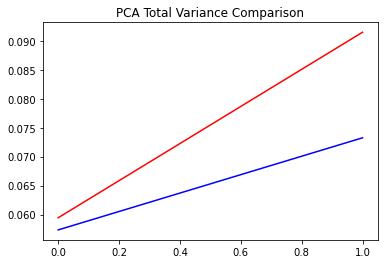

In [66]:
#dm.createDataset
import copy
dm_PurePCA = copy.deepcopy(dm)
dm_PurePCA.createTrainTestData(dataSetMethod='PurePCA_randomequalflamesplit',
                               numCpvComponents=2, ipscaler=None, opscaler=None)

X,Y,rom,zmix = dm_PurePCA.getAllData()
PurePCA = inspect_PCA(X)
print(PurePCA['Var'])
print(DNN_PCA['Var'])

plt.plot(PurePCA['CumVar']/FullDataset['Var'].sum(), color='r')
plt.plot(DNN_PCA['CumVar']/FullDataset['Var'].sum(), color='b')
plt.title('PCA Total Variance Comparison')

### NOTE: This is Amol's half-finished code for opening/inspecting best models

In [11]:
bestModel, experimentSettings = expExectr.modelFactory.openBestModel()
linearAutoEncoder = expExectr.modelFactory.getLinearEncoder()
dm.createTrainTestData(experimentSettings.get('dataSetMethod'), experimentSettings.get('noOfCpv'), experimentSettings.get('inputScaler'), experimentSettings.get('outputScaler'))


#X_train, X_test, Y_train, Y_test, rom_train, rom_test, zmix_train, zmix_test = dm.getTrainTestData() 

X,Y,rom,zmix = dm.getAllData()

pcdnnv2LinearEmbedding = linearAutoEncoder.predict(X)

print (pcdnnv2LinearEmbedding)

#Get the Regressor
regressor = expExectr.modelFactory.getRegressor()

#df_pcdnnv2LinearEmbedding.to_csv('PCDNNV2_Linear_Embeddings.csv', sep='\t',encoding='utf-8', index=False)



NameError: name 'expExectr' is not defined

In [12]:
experimentSettings

{'dataSetMethod': 'AllSpeciesAndZmix_randomequalflamesplit',
 'ipscaler': 'MinMaxScaler',
 'opscaler': 'MinMaxScaler',
 'noOfCpv': 2,
 'ZmixPresent': 'Y',
 'concatenateZmix': 'Y',
 'kernel_constraint': 'Y',
 'kernel_regularizer': 'Y',
 'activity_regularizer': 'Y'}

In [11]:
from model_analyzer.model_analysis import *

# NOTE: this code was produced by inspecting the logic flow
# for the last PCDNNv2 experiment to happen in debug mode
# Create dataset for PCDNNV2...
noOfCpv=3
dataSetMethod='AllSpeciesAndZmix_randomequaltraintestsplit'
experiment_settings = {'dataSetMethod': dataSetMethod, 'noOfCpv': noOfCpv,
                       'inputScaler': "MinMaxScaler", 'outputScaler': "MinMaxScaler"}
#dm.createTrainTestData(dataSetMethod, noOfCpv, "MinMaxScaler", "MinMaxScaler")
model = exprExec.model

In [7]:
from model_analyzer.model_analysis import *
import importlib
importlib.reload(model_analysis)

#import pickle
#with open('GP_model.pickle', 'rb') as f:
#    GP_model = pickle.load(f)

# NOTE: this code was produced by inspecting the logic flow for the last GP experiment to happen in debug mode
# Create dataset for GP...
noOfCpv = 1
dataSetMethod='ZmixCpv_frameworkincludedtrainexcludedtest'

experiment_settings = {'dataSetMethod': dataSetMethod, 'noOfCpv': noOfCpv,
                       'inputScaler': None, 'outputScaler': None}

#dm.createTrainTestData(dataSetMethod, noOfCpv, None, None)

In [34]:
model = exprExec.model
inspector = model_analysis.ModelInspector(model, dm, experiment_settings)
inspector.plot_permutation_feature_importance(n_repeats=1)

ValueError: in user code:

    /home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape (None, 1)


         Zmix       Cpv
min  0.004734  0.005323
25%  0.211188  0.362239
50%  0.394441  0.598406
75%  0.629945  0.800664
max  0.995112  0.993052


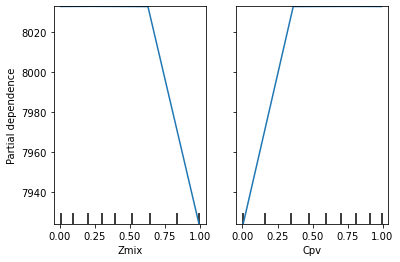

In [8]:
inspector.plot_partial_dependence()

In [9]:
"""
NN_wrapped = NNWrapper(NN)
X_data, Y_data = NN_wrapped.get_XY_data(dm)
do_perm_feature_importance(NN_wrapped, X_data, Y_data, n_repeats=5)
"""

Zmix; 85825945.600 +/- 3203524.099
YiH2O; 16279142.400 +/- 493220.993
YiC2H2; 1677721.600 +/- 52428.800
YiOH; 1625292.800 +/- 104857.600
YiH2; 917504.000 +/- 82897.211
YiHCCO; 812646.400 +/- 52428.800
YiCO; 707788.800 +/- 64211.904
YiO; 707788.800 +/- 104857.600
YiHO2; 131072.000 +/- 0.000
YiH; 131072.000 +/- 0.000
YiCH2(S); 131072.000 +/- 0.000
YiCH2OH; 131072.000 +/- 0.000


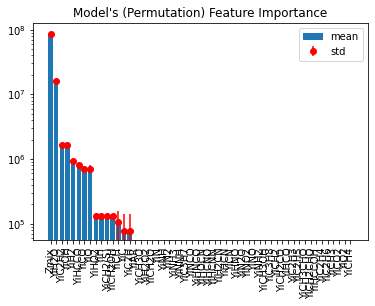

In [10]:
"""
# this gives us the same dataframe but with only quartiles for each variable
# thereby covering the relevant ranges but much faster
X_chunky=X_data.describe().iloc[3:]
print(X_chunky)

plot_partial_dependence(NN_wrapped, X_chunky, list(range(25)))
"""

In [25]:
"""
from model_analyzer.model_analysis import *

import pickle
with open('GP_model.pickle', 'rb') as f:
    GP_model = pickle.load(f)

# NOTE: this code was produced by inspecting the logic flow for the last GP experiment to happen in debug mode
# Create dataset for GP...
noOfCpv = 1
dataSetMethod='ZmixCpv_frameworkincludedtrainexcludedtest'

experiment_settings = {}

dm.createTrainTestData(dataSetMethod, noOfCpv, None, None)
"""

In _createTrainTestData Y_test.shape: (12857, 1)
In createTrainTestData Y_test.shape: (12857, 1)


In [26]:
"""
GP_model = GPWrapper(GP_model)

X_data, Y_data = GP_model.get_XY_data(dm)
print(X_data)
print(Y_data)

do_perm_feature_importance(GP_model, X_data, Y_data, n_repeats=2)
"""

           Zmix       Cpv
0      0.004907  0.038576
1      0.010652  0.083829
2      0.015384  0.121240
3      0.019621  0.154899
4      0.023542  0.186212
...         ...       ...
12852  0.962252  0.043816
12853  0.969814  0.035038
12854  0.977742  0.025835
12855  0.986128  0.016102
12856  0.995112  0.005674

[12857 rows x 2 columns]
            souener
0      1.127077e+09
1      2.012383e+09
2      2.340244e+09
3      2.336164e+09
4      2.203924e+09
...             ...
12852  3.163469e+07
12853  2.314512e+07
12854  1.471774e+07
12855  6.875205e+06
12856  1.064129e+06

[12857 rows x 1 columns]


In [9]:
"""
# this gives us the same dataframe but with only quartiles for each variable
# thereby covering the relevant ranges but much faster
X_chunky=X_data.describe().iloc[3:]
print(X_chunky)

plot_partial_dependence(GP_model, X_chunky, list(range(2)))
"""

'\n# this gives us the same dataframe but with only quartiles for each variable\n# thereby covering the relevant ranges but much faster\nX_chunky=X_data.describe().iloc[3:]\nprint(X_chunky)\n\nplot_partial_dependence(GP_model, X_chunky, list(range(2)))\n'

In [31]:
"""
inspector = ModelInspector(GP_model, dm)
inspector.plot_permutation_feature_importance()
"""

Zmix; 50056872019535855616.000 +/- 176526134266102016.000
Cpv; 44012058431847006208.000 +/- 142509008580537824.000


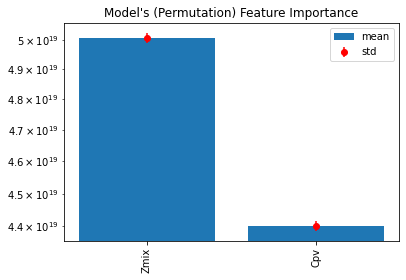

In [44]:
# inspector.plot_partial_dependence()

### NOTE: This is Amol's half-finished code for opening/inspecting best models

In [36]:
bestModel, experimentSettings = expExectr.modelFactory.openBestModel()
linearAutoEncoder = expExectr.modelFactory.getLinearEncoder()
dm.createTrainTestData(experimentSettings.get('dataSetMethod'), experimentSettings.get('noOfCpv'),
                       experimentSettings.get('inputScaler'), experimentSettings.get('outputScaler'))


#X_train, X_test, Y_train, Y_test, rom_train, rom_test, zmix_train, zmix_test = dm.getTrainTestData() 

X,Y,rom,zmix = dm.getAllData()

pcdnnv2LinearEmbedding = linearAutoEncoder.predict(X)

print (pcdnnv2LinearEmbedding)

#Get the Regressor
regressor = expExectr.modelFactory.getRegressor()

#df_pcdnnv2LinearEmbedding.to_csv('PCDNNV2_Linear_Embeddings.csv', sep='\t',encoding='utf-8', index=False)


NameError: name 'expExectr' is not defined

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
linear_embedding (Functional)   (None, 2)            108         species_input[0][0]              
__________________________________________________________________________________________________
concatenated_zmix_linear_embedd (None, 3)            0           zmix[0][0]                       
                                                                 linear_embedding[0][0]     

In [31]:
experimentSettings

{'dataSetMethod': 'AllSpeciesAndZmix_randomequalflamesplit',
 'ipscaler': 'MinMaxScaler',
 'opscaler': 'MinMaxScaler',
 'noOfCpv': 2,
 'ZmixPresent': 'Y',
 'concatenateZmix': 'Y',
 'kernel_constraint': 'Y',
 'kernel_regularizer': 'Y',
 'activity_regularizer': 'Y'}

In [47]:
FullDataset['X']

NameError: name 'FullDataset' is not defined

In [9]:
import numpy as np
np.std([1,2])

0.5